# GeocodeNet


## Objective 

A geocode operation is a process to translate a geographic entity in a code. 

For example, we want to translate this french address : 

    Route du Tréport 80230 Saint-Valery-sur-Somme
    
Into geographic coordinate, longitude and latitude : 

    47,0.504549603611111 0.7787510938888894
    
## Issue 

When the address are misspelled or contain error, it's much more difficult to find coordinate. 
You may also want to transform address into linear values in order to use it in another machine learning process.

We our previous exemple, it could be something like that: 

    Rte du trepot saint-valery / somme
    

## Character Convolutions Neural Network to the rescue

To solve that issue, we will use the Character-level Convolutional Networks for Text Classification detailed here : 

Xiang Zhang, Junbo Zhao, Yann LeCun. [Character-level Convolutional Networks for Text Classification](http://arxiv.org/abs/1509.01626). NIPS 2015

We will modify the neural network to learn multi-output regression instead of classification. 

/!\ Not yet implemented

We will also augmented the train dataset by added, synthetically generate as many, random permutations:
- Character substitution (using nearby characters on the keyboard)
- Deletion
- Transposition
- Duplication

### Result 

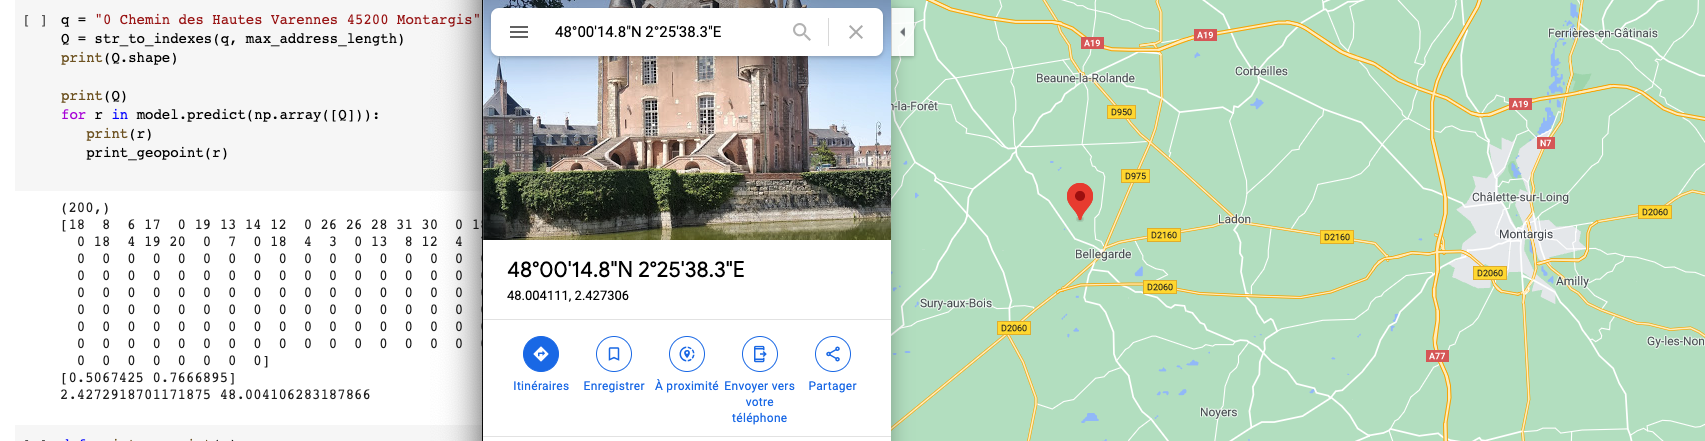



<a href="https://colab.research.google.com/github/scampion/geocodenet/blob/main/geocodenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install keras-metrics

## Load and prepare data

CSV sample : `lat, lon, postcode, city, street, number`

    38,0.49830201027777776,0.7682701011111116,53100,Mayenne,Rue de la Peyennière,0
    39,0.49830201027777776,0.7682701011111116,53100,Mayenne,,
    46,0.5165364863888888,0.7531874688888894,73230,Saint-Alban-Leysse,,
    47,0.504549603611111,0.7787510938888894,80230,Saint-Valery-sur-Somme,Route du Tréport,0


In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    csv_filepath = "/content/drive/My Drive/data/geocodenet/france.csv"
else: 
    csv_filepath = "france.csv"

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv(csv_filepath)
df.fillna('', inplace=True)
for c in ['number', 'street', 'postalcode', 'city']:    
    df[c].astype(object).replace(np.nan, 'None')
df['address'] = (df['number'] + " " + df['street'] + " " + df['postalcode'] + " " + df['city'])
for c in ['number', 'street', 'postalcode', 'city', 'Unnamed: 0']:
    del df[c]
df.head()

## Load variables

In [ ]:
import json 
config = json.load(open("./config.json"))

max_address_length = config["data"]["input_size"]
alphabet=config["data"]["alphabet"]
alphabet_size = len(alphabet)

## Encode address

A short example: 

    "12 abc" > [28, 29, 0, 1, 2, 3]

In [ ]:
def str_to_indexes(s, max_length):
    s = s.lower()
    str2idx = np.zeros(max_length, dtype='int8')
    for i in range(min(len(s), max_length)): 
        if s[i] in alphabet:
            str2idx[i] = alphabet.index(s[i]) + 1              
    return str2idx
df['address_encoded'] = df['address'].apply(str_to_indexes, max_length=max_address_length)

# Convert to numpy 
nbobs = len(df['address_encoded'])
X = np.concatenate(df['address_encoded'].to_numpy()).ravel()
X = X.reshape(nbobs, max_address_length)
Y = np.concatenate(df[['long', 'lat']].to_numpy()).ravel()
Y = Y.reshape(nbobs, 2)

## TPU management 

Using Colab from Google, you can use TPU to speed up the computing task

In [ ]:
import tensorflow as tf
import os 

tpu_strategy = None
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    tpu_address = 'grpc://' + device_name
    print('Found TPU at: {}'.format(tpu_address))
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    tpu_strategy = tf.distribute.TPUStrategy(cluster_resolver)
except KeyError:
 print('TPU not found')

## NN

In [ ]:
from keras import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Dense, Flatten, Bidirectional, LSTM, Convolution1D, ThresholdedReLU, MaxPooling1D, Dropout
import keras_metrics

input_size = max_address_length
embedding_size = 128
out_dim = 2
embedding_size=config["char_cnn_zhang"]["embedding_size"]
conv_layers=config["char_cnn_zhang"]["conv_layers"]
fully_connected_layers=config["char_cnn_zhang"]["fully_connected_layers"]
threshold=config["char_cnn_zhang"]["threshold"]
dropout_p=config["char_cnn_zhang"]["dropout_p"]
optimizer=config["char_cnn_zhang"]["optimizer"]
loss=config["char_cnn_zhang"]["loss"]

def build_model():
    inputs = Input(shape=(input_size,), name='sent_input', dtype='int64')      
    x = Embedding(alphabet_size + 1, embedding_size, input_length=input_size)(inputs)
    for cl in conv_layers:
      x = Convolution1D(cl[0], cl[1])(x)
      x = ThresholdedReLU(threshold)(x)
      if cl[2] != -1:
          x = MaxPooling1D(cl[2])(x)
    x = Flatten()(x)
    for fl in fully_connected_layers:
      x = Dense(fl)(x)
      x = ThresholdedReLU(threshold)(x)
      x = Dropout(dropout_p)(x)

    predictions = Dense(2, activation='linear')(x)
    model = Model(name="geocodenet", inputs=inputs, outputs=predictions)
    model.compile(optimizer=optimizer, loss=loss, 
                metrics=[keras_metrics.precision(), keras_metrics.recall()])
    model.summary()
    return model
    
if tpu_strategy:
    with tpu_strategy.scope():
        model = build_model()
else:
    model = build_model()    

## Train the model

In [ ]:
epochs=config["training"]["epochs"]
batch_size=config["training"]["batch_size"]
checkpoint_every=config["training"]["checkpoint_every"]
    
print("Training model: ")
model.fit(X, Y, epochs=epochs, batch_size=batch_size, callbacks=[])

In [ ]:
model.evaluate(X[0:20], Y[0:20], verbose=0)